In [1]:
import pandas as pd
import numpy as np
import pickle
import timeit
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

#Logistic Regression 
from sklearn.linear_model import LogisticRegression
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
#KNN
from sklearn.neighbors import KNeighborsClassifier
#SVM
from sklearn import svm
from sklearn.svm import SVC
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.multiclass import OneVsRestClassifier

#Spliting and Testing 
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, roc_curve, auc
from scipy import interp
from sklearn.preprocessing import StandardScaler, label_binarize 
from itertools import cycle




In [2]:
#  Options 
pd.set_option("display.min_rows", 69)

In [3]:
###### Class-00
class HelpEstimatorSelection:

    def __init__(self, models, params, cv=3):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.cv = cv
        self.keys = models.keys()
        self.grid_searches = {}

    
        
    def fit(self, X, y, n_jobs=-1, verbose=1, scoring=None, refit=False):
        def build_pipeline(model):
            if isinstance(model, SGDClassifier):
                kernel_approx = Nystroem('rbf', 0.5, 3, 100)
                pipe = Pipeline([
                    ('KA', kernel_approx),
                    ('clf', model)
                ])
            else:
                pipe = Pipeline([ ('clf', model)])
            return pipe
    
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            pipe = build_pipeline(model)
            params = self.params[key]
            gs = GridSearchCV(pipe, params, cv=self.cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1, sort=True).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [4]:
###### Function-00
def acquire_data(file):
    mnist = loadmat(file)
    mnist_data = mnist["data"].T
    mnist_label = mnist["label"][0]
    mnist_features_df = pd.DataFrame(mnist_data)   
    mnist_label_df = pd.DataFrame(mnist_label)
    return mnist_features_df, mnist_label_df


In [5]:
###### Function-01
def clean_data(features, label):
    features.columns = features.columns.astype(str) 
    label.columns =  label.columns.astype(str)    
    label.columns =  label.columns.astype(str)
    label.columns = ['label']    
    mnist_df = features.merge(label,  on= features.index)    
    mnist_df.drop(columns = ['key_0'], inplace = True)    
    return mnist_df
    

In [6]:
###### Function-02
def mask(class_label):
    avg=df[df.label == class_label].iloc[:,:-1].values.mean(axis=0).astype(int)
    mask=avg> 100
    return mask.reshape(28,28)

In [7]:
###### Function-03
def best_fit_mask(sample_point, masks):
    memebership_list = []
    for mask in masks:
        membership_per= (sample_point*mask.reshape(-1)).sum()/sample_point.sum()
        memebership_list.append(membership_per)
    return(memebership_list.index(max(memebership_list)))

In [8]:
###### Function-04
def score_masks(features_test, label_test, masks):
    predictions = [] 
    for row in features_test.iterrows():
        predictions.append(best_fit_mask(np.array(row[1]), masks))            
    return predictions, accuracy_score(label_test, predictions)

In [9]:
###### Function-05
def mask_memebership(sample_point, masks):
    memebership_list = []
    for mask in masks:
        membership_per= (sample_point*mask.reshape(-1)).sum()/sample_point.sum()
        memebership_list.append(membership_per)
    return(memebership_list)

In [10]:
###### Function-06
def generate_knn_model(features, label, k):
    """"
    Params: 1)features set. 2)labels set. 3)k: number of neighbors.
    Returns training_score, validation_score, K-NN model object
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    print('building the model')
    knn.fit(features, label)
    print('scoring on training dataset')
    training_score = knn.score(features,label)
    return training_score , knn

In [13]:
###### Function-07
def generate_model(models, algorithm, features, labels):
    """"
    Params: 1)List of Models. 2)Chosen algorithm. 3)Training features set. 4)Training labels set. 
    Returns: training_score, classifier object
    """
    classifier = models[algorithm]
    classifier.fit(features, labels) 
    training_score= classifier.score(features,labels) 
    print('Training Score: {}'.format(training_score))
    return training_score, classifier


In [14]:
###### Function-08
def test_model(classifier, features, labels, k_folds):
    """
    Params: 1)Classifier object. 2)Testing features set(DataFrame). 3)Testing labels set(DataFrame). 4)k_folds for cross-validation(int).
    Returns: validation score.
    """
    validation_score= cross_val_score(classifier,features, labels, cv= k_folds).mean()
    print('Validation Score: {}'.format(validation_score))
    return validation_score

In [110]:
###### Function-09
def generate_confusion_matrix(model, features, labels):
    pred = model.predict(features)
    cm = confusion_matrix(labels, pred)
    ax = sns.heatmap(cm, annot=True, fmt="d")
    plt.xlim(-0.7, 10)
    plt.ylim(10,-0.7)
    plt.savefig('figure.png')
    plt.show()

In [113]:
###### Function-10
def plot_ROC_AUC(model, features_train, labels_train, features_test, labels_test):
    # Binarize the output
    bin_label_train = label_binarize(labels_train, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    bin_label_test = label_binarize(labels_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    n_classes = bin_label_train.shape[1]
    
    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)
    predictions = classifier.fit(features_train, bin_label_train).predict(features_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(bin_label_test[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(bin_label_test.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(figsize = [12, 12])
    # plt.plot(fpr["micro"], tpr["micro"],
    #          label='micro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["micro"]),
    #          color='deeppink', linestyle=':', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label='macro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["macro"]),
    #          color='navy', linestyle=':', linewidth=4)

    colors = cycle(['#1f77b4', '#ff7f0e', '#8c564b', '#d62728',
                  '#9467bd', '#2ca02c', '#e377c2', '#7f7f7f',
                  '#bcbd22', '#17becf'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=3,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('figure.png')
    plt.show()

# 1- Data Acquisition 
This project is going to use a popular open source dataset called [MNIST original](https://www.kaggle.com/avnishnish/mnist-original). It is a dataset consisting of 70,000 images of handwritten digits and a label which is the digit value. The features are the pixels of the image which are 784 pixels.

In [17]:
df = clean_data(*acquire_data("mnist-original.mat"))

# Spliting Training an Testing Datasets

Note: The original dataset had the rows sorted  by the lable column ascendingly. Therefore, if we split the data without shffling the rows it will perform the testing on data that it never learned how to classify it. So, I used the __shuffle__ option of train_test_split to make sure the method shuffles the data __before__ splitting.

In [18]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle = True)


# 2- EDA

Let's look at the shape of the dataset 

In [19]:
df.shape

(70000, 785)

In [20]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


It is consisting of 784 features representing the pixels of the image, and a label column which represent the digit I want to classify.

#### Checking for missing values 

In [21]:
[row for row in df.isnull().sum() if row!= 0]

[]

Here's an example of what the features values represent.

In [22]:
example_image= np.array(df_train.iloc[2,:-1]).reshape(28,28)

9.0


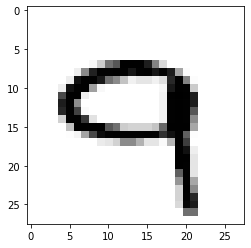

In [23]:
print(df_train.iloc[2, -1])
plt.imshow(example_image, cmap='Greys')

The target distribution plot below show that dataset contains almost even number of samples for each class.

Text(0, 0.5, 'Count')

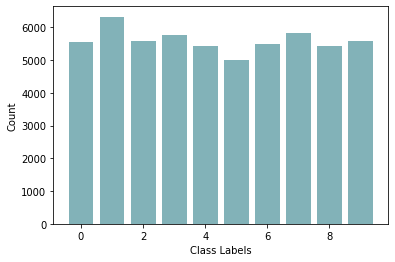

In [24]:
plt.bar( df_train['label'].value_counts().index, df_train['label'].value_counts(), color='#82b2b8')
plt.xlabel('Class Labels')
plt.ylabel('Count')

# 3- Training 

First, I'll start by splitting my training set into train and validation set

In [25]:
train_set, validate_set = train_test_split(df_train, test_size=0.2, shuffle = True)

In [26]:
train_set_labels = train_set.loc[:, train_set.columns == 'label']
train_set_features = train_set.loc[:, train_set.columns != 'label']

In [27]:
validate_set_labels = validate_set.loc[:, validate_set.columns == 'label']
validate_set_features = validate_set.loc[:, validate_set.columns != 'label']

For the purpose of reusibility, I'm going to define a general function that takes an algorithm name and performs the training and validation steps. 

The dictionary below will hold the algorithms objects.

In [28]:
models = {'LR': LogisticRegression(solver = 'lbfgs', multi_class="multinomial"), 
          'KNN': KNeighborsClassifier(n_neighbors=17), 
          'NB': MultinomialNB(),
          'SVM': svm.LinearSVC(),
          'DT': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators= 190)}

# Baseline

Check the file named __baseline__ in the project directory 

# Model-01

This model's idea is to create a mask or a template for each class label in the dataset. The mtemplate is created by taking the features means from every instance at each class. This template will work as a classifier by projecting the test samples through the template and calculate how much pixels made it through this template. The more pixel passes through this template, the more likely this test sample is identical to this digit shape. Check Function-02 to Function-04 for more details about the implementation.

In [29]:
masks = [mask(i) for i in range(0,10)]

Take a look at what the mean of digit 2 looks like.

In [30]:
mask_img= np.array(masks[2]).reshape(28,28)

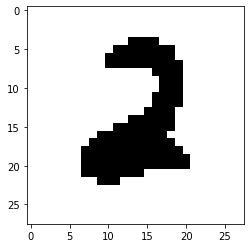

In [31]:
plt.imshow(mask_img, cmap='Greys')

In [32]:
%%time
mask_pred, mask_training_score = score_masks(train_set_features, train_set_labels, masks)

CPU times: user 19.7 s, sys: 78.6 ms, total: 19.8 s
Wall time: 20.1 s


In [33]:
mask_training_score

0.5597098214285714

In [34]:
mask_confusion_matrix= confusion_matrix(train_set_labels, mask_pred )

(10, -0.7)

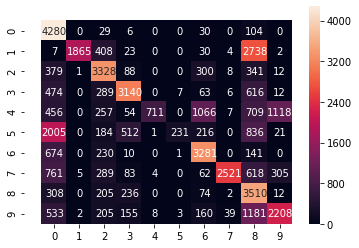

In [35]:
ax = sns.heatmap(mask_confusion_matrix, annot=True, fmt="d")
plt.xlim(-0.7, 10)
plt.ylim(10,-0.7)

# Results Discussion

The performance of this classifier is not as good as I've expected. Therefore, to enhance its performance, I will consider the calculated membership values in Function-03 as features for a new dataset and predict the digit value based on these nine memebership values.

## Feature Engineering

Let's start by __feature engineering__ the dataset, I'll create 10 new features which are the following:
* digit_0: Represents a percentage of the pixels which were able to pass the 0 template. 
* digit_1: Represents a percentage of the pixels which were able to pass the 1 template. 
* digit_2: Represents a percentage of the pixels which were able to pass the 2 template. 
* digit_3: Represents a percentage of the pixels which were able to pass the 3 template. 
* digit_4: Represents a percentage of the pixels which were able to pass the 4 template. 
* digit_5: Represents a percentage of the pixels which were able to pass the 5 template. 
* digit_6: Represents a percentage of the pixels which were able to pass the 6 template. 
* digit_7: Represents a percentage of the pixels which were able to pass the 7 template. 
* digit_8: Represents a percentage of the pixels which were able to pass the 8 template. 
* digit_9: Represents a percentage of the pixels which were able to pass the 9 template. 

In [36]:
train_set_features_transformed = pd.DataFrame(columns = ['digit_0','digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9'])


In [37]:
validate_set_features_transformed = pd.DataFrame(columns = ['digit_0','digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9'])


In [38]:
%%time
for row in train_set_features.iterrows():
    ser = pd.Series(mask_memebership(row[1], masks), index= train_set_features_transformed.columns)
    train_set_features_transformed = train_set_features_transformed.append(ser, ignore_index=True)

CPU times: user 5min 14s, sys: 3.98 s, total: 5min 18s
Wall time: 5min 22s


In [39]:
%%time
for row in validate_set_features.iterrows():
    ser = pd.Series(mask_memebership(row[1], masks), index= validate_set_features_transformed.columns)
    validate_set_features_transformed = validate_set_features_transformed.append(ser, ignore_index=True)

CPU times: user 1min 22s, sys: 857 ms, total: 1min 23s
Wall time: 1min 28s


Take a look at what the generated dataset looks like

In [40]:
train_set_features_transformed.head(3)

,digit_0,digit_1,digit_2,digit_3,digit_4,digit_5,digit_6,digit_7,digit_8,digit_9
0,0.938766,0.150459,0.422304,0.464090,0.272487,0.508361,0.494927,0.352328,0.491920,0.396880
1,0.534857,0.158112,0.464102,0.369990,0.346009,0.405576,0.453420,0.322384,0.622958,0.429320
2,0.401613,0.294328,0.531838,0.380156,0.567754,0.366809,0.513486,0.513949,0.655019,0.593521


## Parameter tuning

In [41]:
# models1 = {
#     'RandomForestClassifier': RandomForestClassifier(),
#     'LogisticRegressionClassifier':  LogisticRegression(),
#     'SGDClassifier': SGDClassifier(),
#     'NBClassifier': MultinomialNB(), 
#     'KNNClassifier': KNeighborsClassifier(), 
# }

# params1 = {
#     'RandomForestClassifier': { 'clf__n_estimators': [i for i in range(10,200,10)]},
#     'LogisticRegressionClassifier': {'clf__C': [0.1, 1] ,'clf__solver': ['lbfgs'], 'clf__multi_class': ['multinomial']},
#     'SGDClassifier': {'clf__class_weight': ['balanced', None], 'clf__max_iter': [500], 
#                       'clf__tol': [1e-3], 'KA__kernel': ['linear', 'poly', 'rbf'], 'KA__gamma': [0.5, 1], 
#                       'KA__degree': [1, 3], 'KA__n_components': [10, 100]},
#     'NBClassifier': {},
#     'KNNClassifier': {'clf__n_neighbors': [i for i in range(5,20,3)]}
# }

In [43]:
# helper1 = HelpEstimatorSelection( models1, params1, cv=10)
# helper1.fit(membership_df, label_train, scoring='accuracy', n_jobs=-1)

# helper1.score_summary(sort_by='mean_score')

##### The results of the above two cells are stored in the following pickled dataframe:

In [44]:
filename = 'GS_df'

In [45]:
infile = open(filename,'rb')
GS_df = pickle.load(infile)
infile.close()

## Modeling Experiments

### A- Build a Logistic Regression model using the features engineered dataset:

In [46]:
%%time
LR_train_score, LR = generate_model(models, 'LR',train_set_features_transformed, train_set_labels.values.ravel())


Training Score: 0.7968973214285714
CPU times: user 5.08 s, sys: 372 ms, total: 5.46 s
Wall time: 3.19 s


/Users/hi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [115]:
LR_train_score

0.7968973214285714

In [47]:
LR_validation_score = test_model(LR, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)


/Users/hi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/hi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/hi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/hi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/hi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

Validation Score: 0.7830345709978889


/Users/hi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### B- Build a KNN model usingthe features engineered dataset:

Building the classifier object with __k = 17__:

In [48]:
%%time
KNN17_train_score_, knn17 = generate_model(models, 'KNN',train_set_features_transformed, train_set_labels.values.ravel())



Training Score: 0.9047321428571429
CPU times: user 12.4 s, sys: 100 ms, total: 12.5 s
Wall time: 13.1 s


Testing the classifier performance:

In [49]:
%%time
KNN17_validation_score = test_model(knn17, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)

Validation Score: 0.8655348744066466
CPU times: user 1.79 s, sys: 28.7 ms, total: 1.81 s
Wall time: 1.89 s


###### k = 5 

In [50]:
%%time
KNN5_train_score, knn5 = generate_knn_model(train_set_features_transformed, train_set_labels.values.ravel(), 5)


building the model
scoring on training dataset
CPU times: user 9.16 s, sys: 77.6 ms, total: 9.24 s
Wall time: 9.37 s


In [51]:
KNN5_train_score

0.9253794642857143

In [52]:
KNN5_validation_score = test_model(knn5, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)


Validation Score: 0.8700813830669443


###### k = 8

In [53]:
%%time
KNN8_train_score, knn8 = generate_knn_model(train_set_features_transformed, train_set_labels.values.ravel(), 8)


building the model
scoring on training dataset
CPU times: user 10.6 s, sys: 194 ms, total: 10.8 s
Wall time: 11.2 s


In [54]:
KNN8_train_score

0.9167633928571428

In [55]:
KNN8_validation_score = test_model(knn8, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)


Validation Score: 0.8714223545896977


###### k = 11

In [56]:
%%time
KNN11_train_score, knn11 = generate_knn_model(train_set_features_transformed, train_set_labels.values.ravel(), 11)


building the model
scoring on training dataset
CPU times: user 10.4 s, sys: 45.8 ms, total: 10.4 s
Wall time: 10.5 s


In [57]:
KNN11_train_score

0.9105580357142857

In [58]:
KNN11_validation_score = test_model(knn11, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)


Validation Score: 0.8698202140114892


###### k = 14

In [59]:
%%time
KNN14_train_score, knn14 = generate_knn_model(train_set_features_transformed, train_set_labels.values.ravel(), 14)


building the model
scoring on training dataset
CPU times: user 11.3 s, sys: 89.9 ms, total: 11.4 s
Wall time: 11.5 s


In [60]:
KNN14_train_score

0.9074330357142857

In [70]:
KNN14_validation_score = test_model(knn14, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)


Validation Score: 0.8694592514078205


Now, we find the model with least liklihood of overfitting. 

In [102]:
scores_table = pd.DataFrame({'k_number': [17, 5, 8, 11, 14],
                            'Train_Score': [ KNN17_train_score_, KNN5_train_score, KNN8_train_score, KNN11_train_score, KNN14_train_score],
                            'Validation_score': [KNN17_validation_score, KNN5_validation_score, KNN8_validation_score, KNN11_validation_score, KNN14_validation_score]})


In [103]:
scores_table['diff']= scores_table['Train_Score'] - scores_table['Validation_score']

In [104]:
scores_table.sort_values(by='diff', ascending=True)

,k_number,Train_Score,Validation_score,diff
4,14,0.907433,0.869459,0.037974
0,17,0.904732,0.865535,0.039197
3,11,0.910558,0.869820,0.040738
2,8,0.916763,0.871422,0.045341
1,5,0.925379,0.870081,0.055298


This shows that k = 14 has the least liklihood of overfitting. 

### C- Build a Naive Bayes model using the features engineered dataset:

In [62]:
%%time
NB_train_score, NB = generate_model(models, 'NB',train_set_features_transformed, train_set_labels.values.ravel())


Training Score: 0.5708035714285714
CPU times: user 41.5 ms, sys: 3.83 ms, total: 45.3 ms
Wall time: 42.1 ms


In [63]:
NB_validation_score = test_model(NB, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)


Validation Score: 0.5119521519814474


### D- Build SVM model using the features engineered dataset:

In [64]:
%%time
SVM_train_score, SVM = generate_model(models, 'SVM',train_set_features_transformed, train_set_labels.values.ravel())


Training Score: 0.7738839285714286
CPU times: user 3.82 s, sys: 43.6 ms, total: 3.87 s
Wall time: 3.97 s


In [65]:
SVM_validation_score = test_model(SVM, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)


Validation Score: 0.7752633990113293


### E- Build a Random Forest model using the features engineered dataset:

In [66]:
%%time
RF_train_score, RF = generate_model(models, 'RF',train_set_features_transformed, train_set_labels.values.ravel())


Training Score: 1.0
CPU times: user 38 s, sys: 235 ms, total: 38.2 s
Wall time: 38.4 s


In [67]:
RF_validation_score = test_model(RF, validate_set_features_transformed, validate_set_labels.values.ravel(), 10)


Validation Score: 0.8583008682960893


# 4- Models Evaluation 

### A- Logistic Regression

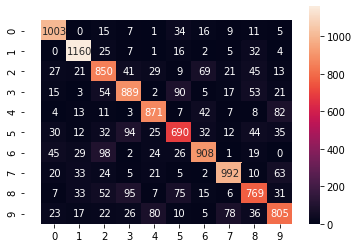

In [140]:
generate_confusion_matrix(LR, validate_set_features_transformed, validate_set_labels)

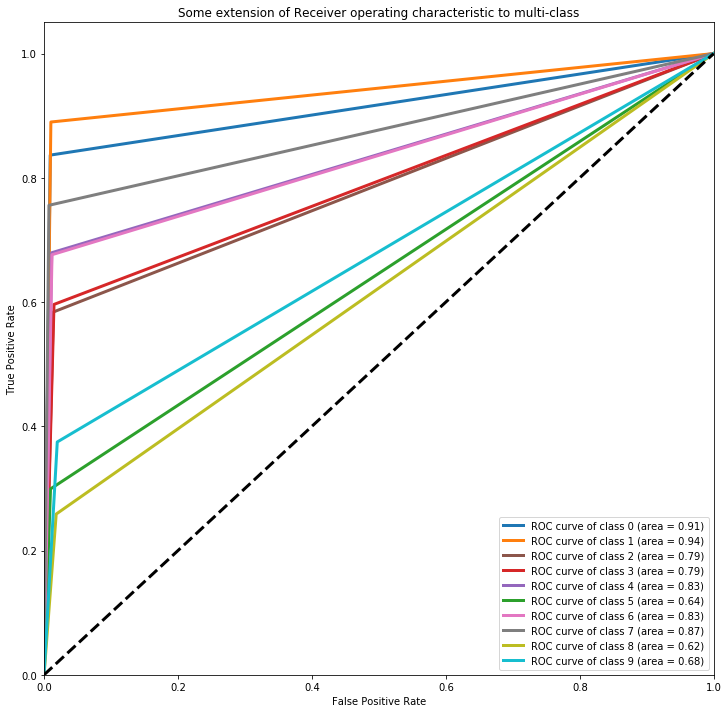

In [141]:
plot_ROC_AUC(LR, train_set_features_transformed, train_set_labels, validate_set_features_transformed, validate_set_labels)


### B- KNN

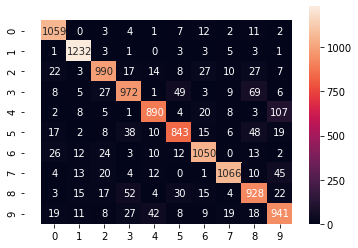

In [78]:
generate_confusion_matrix(knn17, validate_set_features_transformed, validate_set_labels)

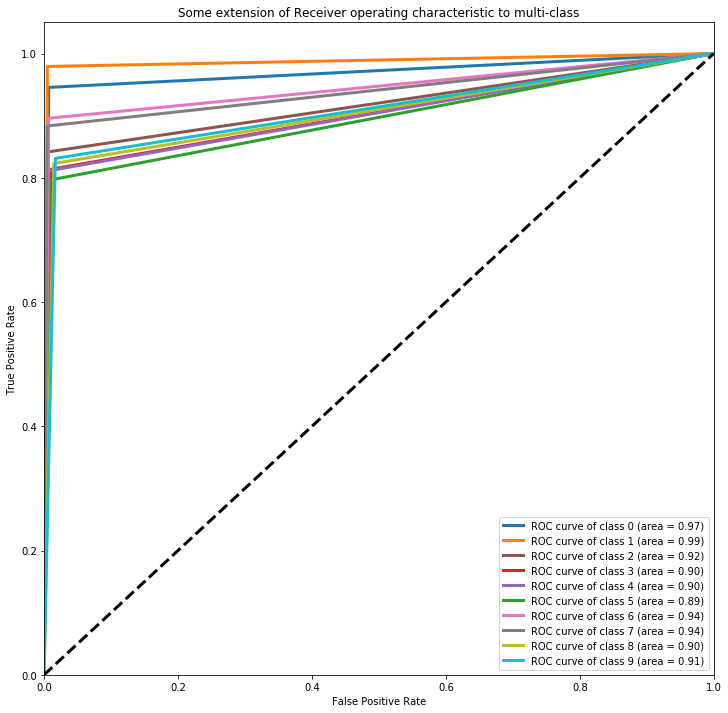

In [79]:
plot_ROC_AUC(knn17, train_set_features_transformed, train_set_labels, validate_set_features_transformed, validate_set_labels)


### C- Naive Bayes

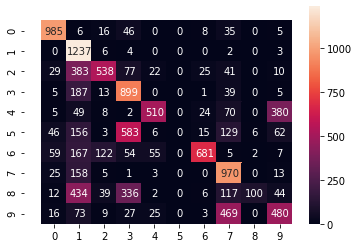

In [142]:
generate_confusion_matrix(NB, validate_set_features_transformed, validate_set_labels)

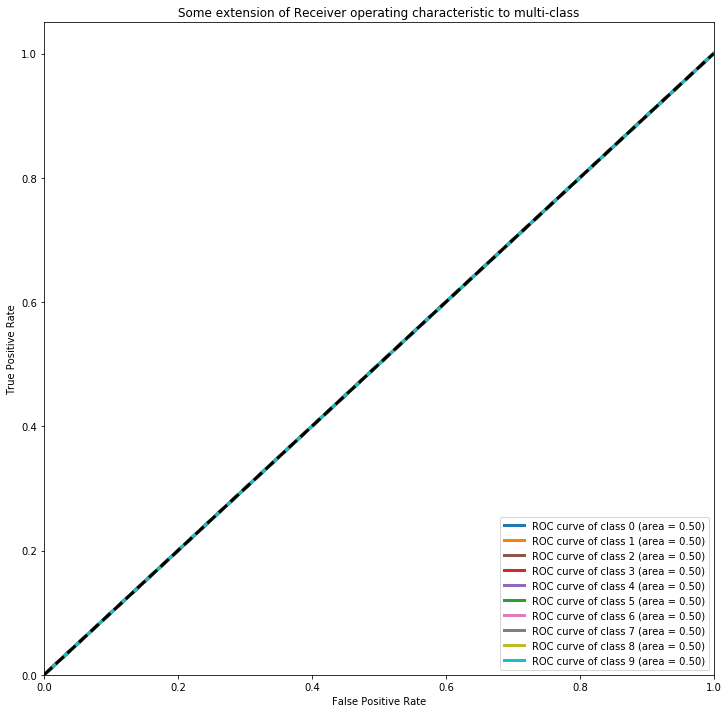

In [143]:
plot_ROC_AUC(NB, train_set_features_transformed, train_set_labels, validate_set_features_transformed, validate_set_labels)


### D- SVM

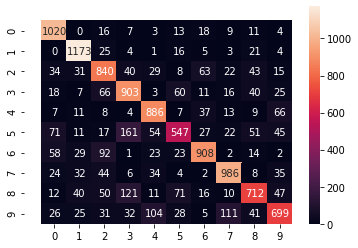

In [144]:
generate_confusion_matrix(SVM, validate_set_features_transformed, validate_set_labels)

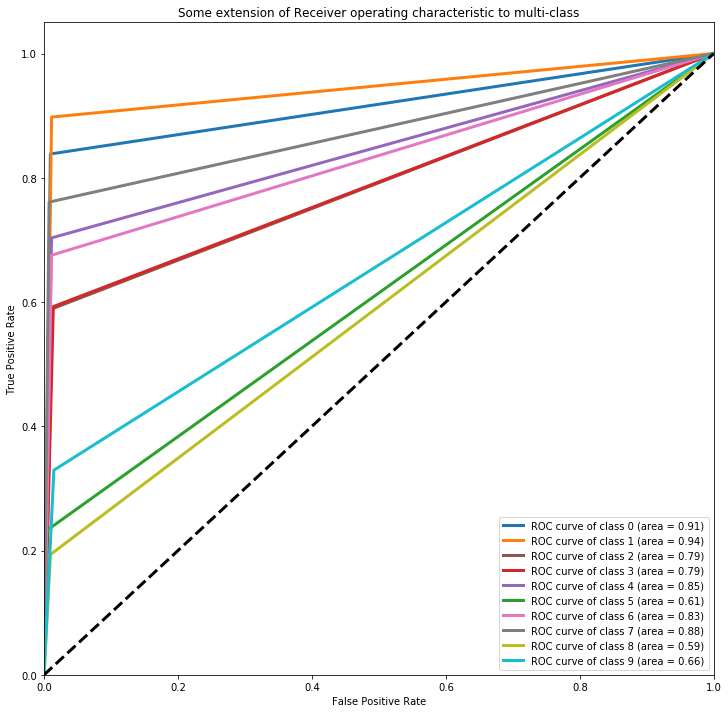

In [145]:
plot_ROC_AUC(SVM, train_set_features_transformed, train_set_labels, validate_set_features_transformed, validate_set_labels)


### E- Random Forest

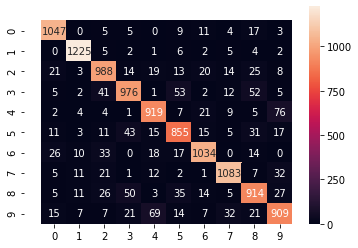

In [146]:
generate_confusion_matrix(RF, validate_set_features_transformed, validate_set_labels)

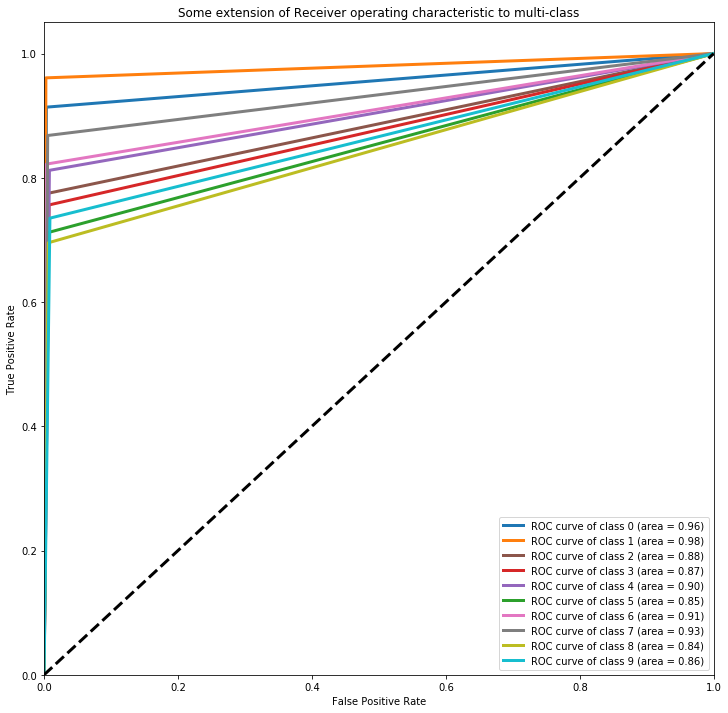

In [147]:
plot_ROC_AUC(RF, train_set_features_transformed, train_set_labels, validate_set_features_transformed, validate_set_labels)


# 5- Model Deploying and Testing

After experimenting with different models, KNN seems to be the model performing the best with least overfitting chance, better confusion matrix results, and highest AUC of minimum class.

In [86]:
label_test = df_test.loc[:, df_test.columns == 'label']
features_test = df_test.loc[:, df_test.columns != 'label']

In [87]:
test_set_features_transformed = pd.DataFrame(columns = ['digit_0','digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9'])


In [88]:
%%time
for row in features_test.iterrows():
    ser = pd.Series(mask_memebership(row[1], masks), index= test_set_features_transformed.columns)
    test_set_features_transformed = test_set_features_transformed.append(ser, ignore_index=True)
    

CPU times: user 1min 46s, sys: 1.26 s, total: 1min 48s
Wall time: 1min 54s


In [105]:
test_score = test_model(knn14, test_set_features_transformed, label_test.values.ravel(), 10)

Validation Score: 0.8710723635491066


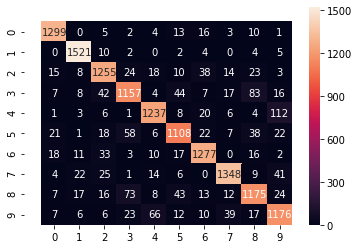

In [111]:
generate_confusion_matrix(knn14, test_set_features_transformed, label_test)

In [107]:
f_train_set80 = pd.concat([train_set_features_transformed, validate_set_features_transformed]) 


In [108]:
l_train_set80 = pd.concat([train_set_labels, validate_set_labels])

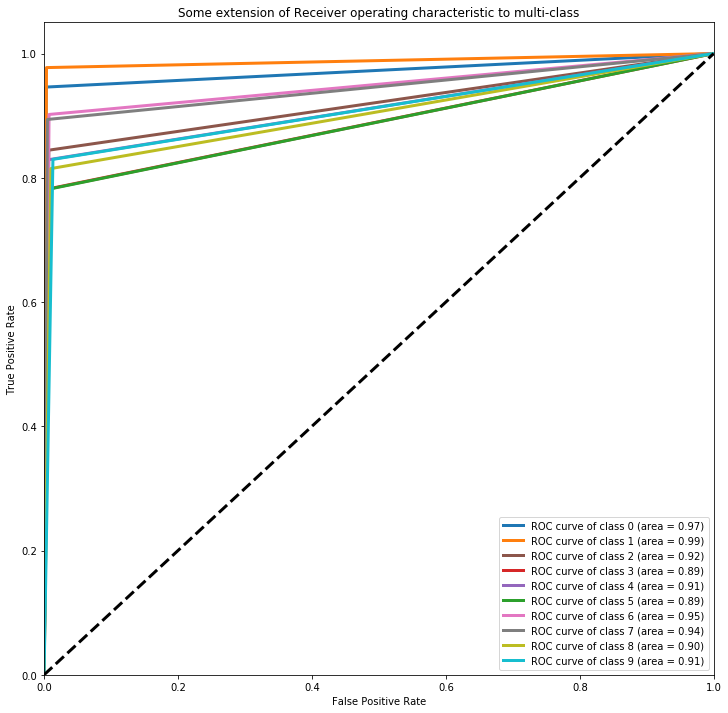

In [114]:
plot_ROC_AUC(knn14, f_train_set80, l_train_set80, test_set_features_transformed, label_test)


### Sample Tests

In [129]:
predictions = knn14.predict(test_set_features_transformed)

In [130]:
sample_test_img1= np.array(features_test.iloc[0,:]).reshape(28,28)

Predictid Label: 5.0


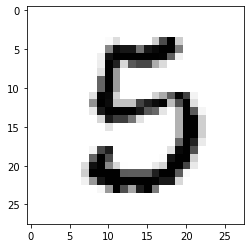

In [134]:
print("Predictid Label: " + str(predictions[0]))
plt.imshow(sample_test_img1, cmap='Greys')

In [132]:
sample_test_img2= np.array(features_test.iloc[1,:]).reshape(28,28)

Predictid Label: 0.0


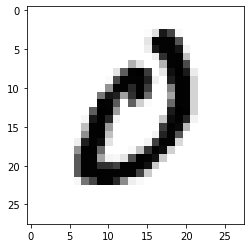

In [135]:
print("Predictid Label: " + str(predictions[1]))
plt.imshow(sample_test_img2, cmap='Greys')

In [136]:
sample_test_img3= np.array(features_test.iloc[2,:]).reshape(28,28)

Predictid Label: 7.0


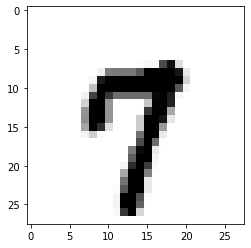

In [137]:
print("Predictid Label: " + str(predictions[2]))
plt.imshow(sample_test_img3, cmap='Greys')

In [138]:
sample_test_img4= np.array(features_test.iloc[3,:]).reshape(28,28)

Predictid Label: 1.0


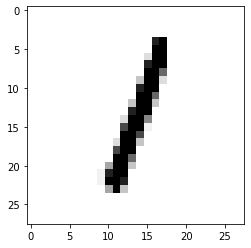

In [139]:
print("Predictid Label: " + str(predictions[3]))
plt.imshow(sample_test_img4, cmap='Greys')